# HLS Burn Scars

## Task: Adapt the notebook yourself to perform fine-tuning with TerraMind on HLS Burn Scars.

You find several TODOs in this notebook.

Use the dataset description (https://huggingface.co/datasets/ibm-nasa-geospatial/hls_burn_scars) and the TerraMind docs (https://terrastackai.github.io/terratorch/stable/guide/terramind/) to solve the TODOs.

# Setup

In colab: 
1. Go to "Runtime" -> "Change runtime type" -> Select "T4 GPU"
2. Install TerraTorch

In [ ]:
!pip install terratorch==1.1.1
!pip install gdown tensorboard

In [1]:
import os
import torch
import gdown
import terratorch
import albumentations
import numpy as np
import lightning.pytorch as pl
import matplotlib.pyplot as plt
from pathlib import Path
from terratorch.datamodules import GenericNonGeoSegmentationDataModule
import warnings
warnings.filterwarnings("ignore")

3. Download the dataset from Google Drive

In [ ]:
# This version is an adaptation from https://huggingface.co/datasets/ibm-nasa-geospatial/hls_burn_scars (same data, updated folder structure) with splits from https://github.com/IBM/peft-geofm/tree/main/datasets_splits/burn_scars. You can also download the original data from Hugging Face.

if not os.path.isfile('hls_burn_scars.tar.gz'):
    gdown.download("https://drive.google.com/uc?id=1yFDNlGqGPxkc9lh9l1O70TuejXAQYYtC")

if not os.path.isdir('hls_burn_scars/'):
    !tar -xzf hls_burn_scars.tar.gz

## HLS Burn Scars Dataset

Lets start with analysing the dataset

In [2]:
dataset_path = Path("hls_burn_scars")
!ls "hls_burn_scars"

data   splits


In [3]:
!ls "hls_burn_scars/splits/" | head

test.txt
train.txt
val.txt


In [4]:
!ls "hls_burn_scars/data/" | head

subsetted_512x512_HLS.S30.T10SDH.2020248.v1.4_merged.tif
subsetted_512x512_HLS.S30.T10SDH.2020248.v1.4.mask.tif
subsetted_512x512_HLS.S30.T10SEH.2018190.v1.4_merged.tif
subsetted_512x512_HLS.S30.T10SEH.2018190.v1.4.mask.tif
subsetted_512x512_HLS.S30.T10SEH.2018245.v1.4_merged.tif
subsetted_512x512_HLS.S30.T10SEH.2018245.v1.4.mask.tif
subsetted_512x512_HLS.S30.T10SEH.2018280.v1.4_merged.tif
subsetted_512x512_HLS.S30.T10SEH.2018280.v1.4.mask.tif
subsetted_512x512_HLS.S30.T10SEH.2019305.v1.4_merged.tif
subsetted_512x512_HLS.S30.T10SEH.2019305.v1.4.mask.tif
ls: stdout: Undefined error: 0


In [7]:
!head "hls_burn_scars/splits/train.txt"

T10SEJ.2018185.v1
T10SFE.2020267.v1
T10SFE.2021166.v1
T10SFF.2018155.v1
T10SFF.2018190.v1
T10SFF.2020215.v1
T10SFF.2020250.v1
T10SFF.2021189.v1
T10SFG.2020215.v1
T10SFH.2018185.v1


In [ ]:
import rioxarray as rxr
sample = rxr.open_rasterio('hls_burn_scars/data/subsetted_512x512_HLS.S30.T10SDH.2020248.v1.4_merged.tif')
sample

TerraTorch provides generic data modules that work directly with PyTorch Lightning. For single-modal datasets we recommend the `GenericNonGeoSegmentationDataModule`.
Check the docs for the parameters.

Data module: https://terrastackai.github.io/terratorch/stable/package/generic_datamodules/#terratorch.datamodules.generic_pixel_wise_data_module.GenericNonGeoSegmentationDataModule

Dataset: https://terrastackai.github.io/terratorch/stable/package/generic_datasets/#terratorch.datasets.generic_pixel_wise_dataset.GenericNonGeoSegmentationDataset

In [24]:
datamodule = terratorch.datamodules.GenericNonGeoSegmentationDataModule(
    batch_size=8,
    num_workers=2,
    num_classes=2,
    rgb_indices=[2, 1, 0],

    # TODO: Define the data and label paths
    train_data_root=None,
    train_label_data_root=None,
    val_data_root=None,
    val_label_data_root=None,
    test_data_root=None,
    test_label_data_root=None,

    # TODO: Define the split files
    train_split=None,
    val_split=None,
    test_split=None,

    # TODO: Define suffixs
    img_grep=None,
    label_grep=None,

    # TODO: Update the standardization values. They need to be the same length as the data.
    #  You can define a constant_scale that applies a multiplicator in case the data does not align with the the standardization values.
    constant_scale=None,
    means=None,
    stds=None,
    # fyi TerraMind pretraining values (assuming data in range 0-10000)
    # S2L2A means: [1390.458, 1503.317, 1718.197, 1853.910, 2199.100, 2779.975, 2987.011, 3083.234, 3132.220, 3162.988, 2424.884, 1857.648]
    # S2L2A stds: [2106.761, 2141.107, 2038.973, 2134.138, 2085.321, 1889.926, 1820.257, 1871.918, 1753.829, 1797.379, 1434.261, 1334.311]

    # albumentations supports shared transformations and can handle multimodal inputs.
    train_transform=[
        albumentations.D4(), # Random flips and rotation
        albumentations.pytorch.transforms.ToTensorV2(),
    ],
    val_transform=None,  # Fallback to ToTensor
    test_transform=None,

    no_label_replace=-1,  # Replace NaN labels. defaults to -1 which is ignored in the loss and metrics.
    no_data_replace=0,  # Replace NaN data
)

# Setup train and val datasets
datamodule.setup("fit")

In [12]:
# checking datasets validation split size
val_dataset = datamodule.val_dataset
len(val_dataset)

160

In [25]:
# Helper function for plotting both modalities
def plot_sample(sample):
    data = sample['image'].cpu().numpy()
    mask = sample['mask'].cpu().numpy()

    # Scaling data.
    data = data * 10000
    data = (data.clip(0, 2000) / 2000) * 255
    rgb = data[[2, 1, 0]].astype(np.uint8).transpose(1,2,0)

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(rgb)
    ax[0].set_title('Image')
    ax[0].axis('off')
    ax[1].imshow(mask, vmin=-1, vmax=1, interpolation='nearest')
    ax[1].set_title('Mask')
    ax[1].axis('off')
    ax[2].imshow(rgb)
    ax[2].imshow(mask, vmin=-1, vmax=1, interpolation='nearest', alpha=0.5)
    ax[2].set_title('Mask on Image')
    ax[2].axis('off')
    fig.tight_layout()
    plt.show()

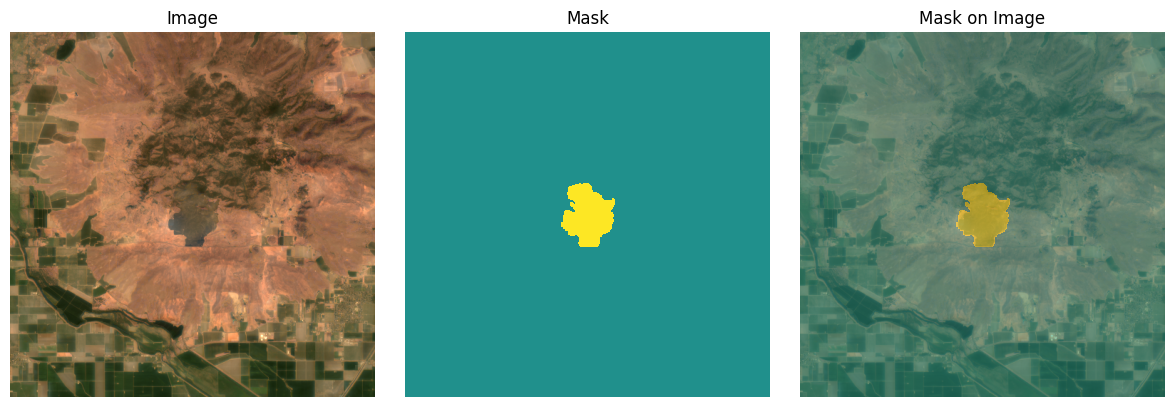

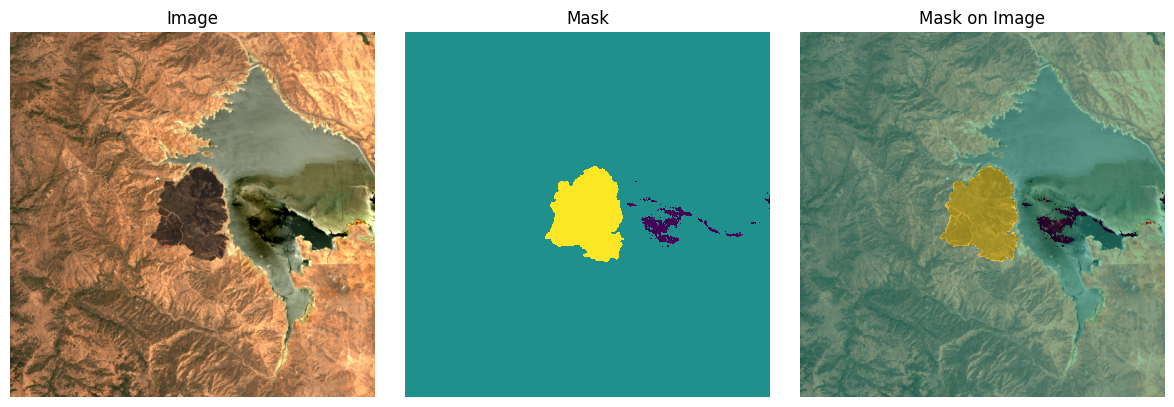

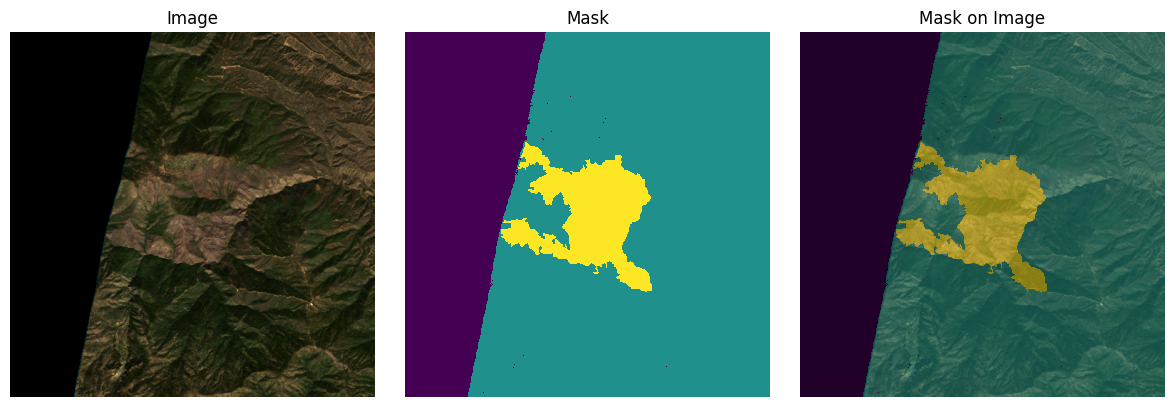

In [26]:
# Plotting a few samples
plot_sample(val_dataset[0])
plot_sample(val_dataset[1])
plot_sample(val_dataset[2])

# The GenericMultiModalDataModule has an integrated plotting function.
# We use a custom one because the 0-2000 scaling looks a bit nicer than the min-max scaling of the integrated function.

# val_dataset.plot(val_dataset[0])
# plt.show()

In [15]:
# checking datasets testing split size
datamodule.setup("test")
test_dataset = datamodule.test_dataset
len(test_dataset)

120

# Fine-tune TerraMind via PyTorch Lightning

With TerraTorch, we can use standard Lightning components for the fine-tuning.
These include callbacks and the trainer class.
TerraTorch provides EO-specific tasks that define the training and validation steps.
In this case, we are using the `SemanticSegmentationTask`.
We refer to the [TerraTorch paper](https://arxiv.org/abs/2503.20563) for a detailed explanation of the TerraTorch tasks.

In [ ]:
pl.seed_everything(0)

# By default, TerraTorch saves the model with the best validation loss. You can overwrite this by defining a custom ModelCheckpoint, e.g., saving the model with the highest validation mIoU.  
# TODO Optionally adjust the checkpoint
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=None,
    mode="max",
    monitor="val/mIoU", # Variable to monitor
    filename="best-mIoU",
    save_weights_only=True,
)

# Lightning Trainer
trainer = pl.Trainer(
    accelerator="auto",
    strategy="auto",
    devices=1, # Deactivate multi-gpu because it often fails in notebooks
    precision="16-mixed",  # Speed up training with half precision, delete for full precision training.
    num_nodes=1,
    logger=True,  # Uses TensorBoard by default
    max_epochs=3, # For demos
    log_every_n_steps=1,
    callbacks=[checkpoint_callback, pl.callbacks.RichProgressBar()],
    # TODO Define output dir
    default_root_dir=None,
)

# Segmentation mask that build the model and handles training and validation steps.  
model = terratorch.tasks.SemanticSegmentationTask(
    model_factory="EncoderDecoderFactory",  # Combines a backbone with necks, the decoder, and a head
    model_args={
        # TerraMind backbone
        "backbone": "terramind_v1_small",
        "backbone_pretrained": True,
        # TODO Select the modality. Check the docs for details https://terrastackai.github.io/terratorch/stable/guide/terramind/#subset-of-input-bands
        "backbone_modalities": ["TODO"],
        # TODO define the input bands. This is only needed because you need to select a subset of the pre-training bands for Burn Scars.
        #  Check the names in the "List of pre-trained bands" in the docs.
        "backbone_bands": {"TODO": ["TODO"]},
        
        # Necks 
        "necks": [
            {
                "name": "SelectIndices",
                "indices": [2, 5, 8, 11] # indices for terramind_v1_base
                # "indices": [5, 11, 17, 23] # indices for terramind_v1_large
            },
            {"name": "ReshapeTokensToImage",
             "remove_cls_token": False},  # TerraMind is trained without CLS token, which neads to be specified.
            {"name": "LearnedInterpolateToPyramidal"}  # Some decoders like UNet or UperNet expect hierarchical features. Therefore, we need to learn a upsampling for the intermediate embedding layers when using a ViT like TerraMind.
        ],
        
        # Decoder
        "decoder": "UNetDecoder",
        "decoder_channels": [256, 128, 64, 32],
        
        # Head
        "head_dropout": 0.1,
        "num_classes": 2,
    },
    
    loss="dice",  # We recommend dice for binary tasks and ce for tasks with multiple classes. 
    optimizer="AdamW",
    lr=2e-5,  # The optimal learning rate varies between datasets, we recommend testing different once between 1e-5 and 1e-4. You can perform hyperparameter optimization using terratorch-iterate.  
    ignore_index=-1,
    freeze_backbone=True, # Only used to speed up fine-tuning in this demo, we highly recommend fine-tuning the backbone for the best performance. 
    freeze_decoder=False,  # Should be false in most cases as the decoder is randomly initialized.
    plot_on_val=True,  # Plot predictions during validation steps  
    class_names=["Others", "Burned"]  # optionally define class names
)

In [ ]:
# Before starting the fine-tuning, you can start the tensorboard with:
%load_ext tensorboard
%tensorboard --logdir output

In [ ]:
# Training
trainer.fit(model, datamodule=datamodule)

After fine-tuning, we can evaluate the model on the test set:

In [ ]:
# Let's test the fine-tuned model
best_ckpt_path = "output/terramind_small_burnscars/checkpoints/best-mIoU.ckpt"
trainer.test(model, datamodule=datamodule, ckpt_path=best_ckpt_path)

# Note: This demo only trains for 3 epochs by default, which does not result in good test metrics.

In [ ]:
# Now we can use the model for predictions and plotting
model = terratorch.tasks.SemanticSegmentationTask.load_from_checkpoint(
    best_ckpt_path,
    model_factory=model.hparams.model_factory,
    model_args=model.hparams.model_args,
)

test_loader = datamodule.test_dataloader()
with torch.no_grad():
    batch = next(iter(test_loader))
    images = batch["image"]
    for mod, value in images.items():
        images[mod] = value.to(model.device)
    masks = batch["mask"].numpy()

    with torch.no_grad():
        outputs = model(images)
    
    preds = torch.argmax(outputs.output, dim=1).cpu().numpy()

for i in range(5):
    sample = {
        "image": batch["image"]["S2L2A"][i].cpu(),
        "mask": batch["mask"][i],
        "prediction": preds[i],
    }
    plot_sample(sample)
    # test_dataset.plot(sample)
    # plt.show()
    
# Note: This demo only trains for 5 epochs by default, which does not result in good predictions.

# Burnscars config

If you are struggling with this task, you can check this burn scars config for guidance.

Please note, that this config uses the generic segmentation dataset instead of the generic multimodal dataset. The idea is similar, but the details are a bit different (e.g. dicts of strings).

In [ ]:
# Download config
!wget https://raw.githubusercontent.com/IBM/terramind/refs/heads/main/configs/terramind_v1_base_burnscars.yaml

In [ ]:
# Check the config
!cat terramind_v1_base_burnscars.yaml